# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on 1.3 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [4]:
# maximum number of cells to load from files
max_cells = 50000

# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [5]:
start = time.time()

## Load and Preprocess Data

We load the sparse count matrix from an `h5ad` file using Scanpy. As the entire matrix cannot be placed on the GPU, we have written a function to load the dataset in batches and filter and normalize each batch, then reduce each batch to only selected highly variable genes before combining them into a single matrix. Before filtering the genes, we save 'the 'raw' expression values of the marker genes to use for labeling cells afterward.

In [6]:
preprocess_start = time.time()

In [7]:
%%time
sparse_gpu_array, genes, marker_genes_raw = \
    rapids_scanpy_funcs.preprocess_in_batches(input_file, 
                                              markers, 
                                              min_genes_per_cell=min_genes_per_cell, 
                                              max_genes_per_cell=max_genes_per_cell, 
                                              min_cells_per_gene=min_cells_per_gene, 
                                              target_sum=1e4, 
                                              n_top_genes=n_top_genes,
                                              max_cells=max_cells)

Calculating data size.
Filtering cells
Identifying genes to filter
Filtering genes and normalizing data
Calculating highly variable genes.
Storing raw marker gene expression.
Filtering highly variable genes.
Preprocessing and filtering took 11.205626249313354s
CPU times: user 13.1 s, sys: 3.55 s, total: 16.6 s
Wall time: 16.7 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [8]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 231 ms


And perform regression:

In [9]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

CPU times: user 9.53 s, sys: 9.91 s, total: 19.4 s
Wall time: 19.6 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [10]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = cp.clip(sparse_gpu_array, a_min = -10, a_max=10)
del mean, stddev

CPU times: user 1.11 s, sys: 58.5 ms, total: 1.17 s
Wall time: 1.21 s


In [11]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 37.72287201881409


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [12]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array

CPU times: user 176 ms, sys: 168 ms, total: 344 ms
Wall time: 343 ms


In [13]:
%%time
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 1.73 ms, sys: 1.09 ms, total: 2.82 ms
Wall time: 2.06 ms


### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [14]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)

CPU times: user 923 ms, sys: 198 ms, total: 1.12 s
Wall time: 1.13 s


### t-SNE + K-means

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [15]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

[W] [07:21:15.012466] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 936 ms, sys: 426 ms, total: 1.36 s
Wall time: 1.36 s


In [16]:
%%time
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 168 ms, sys: 40 ms, total: 208 ms
Wall time: 207 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

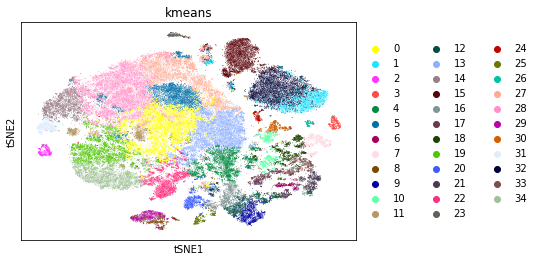

CPU times: user 5.03 s, sys: 3.74 s, total: 8.76 s
Wall time: 1.1 s


In [17]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

We label the cells using the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively. These visualizations show us the separation of neuronal and glial cells on the t-SNE plot.

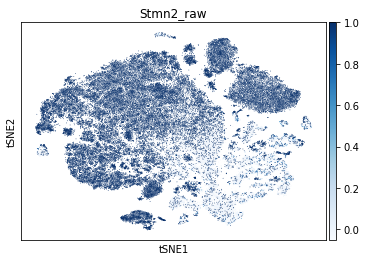

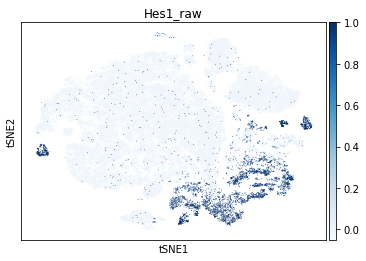

CPU times: user 709 ms, sys: 252 ms, total: 961 ms
Wall time: 468 ms


In [18]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [19]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 6.34 s, sys: 215 ms, total: 6.55 s
Wall time: 6.76 s


The UMAP function from Rapids is also integrated into Scanpy.

In [20]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 241 ms, sys: 46.8 ms, total: 288 ms
Wall time: 287 ms


Next, we use the Louvain algorithm for graph-based clustering.

In [21]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 74.1 ms, sys: 43 ms, total: 117 ms
Wall time: 116 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

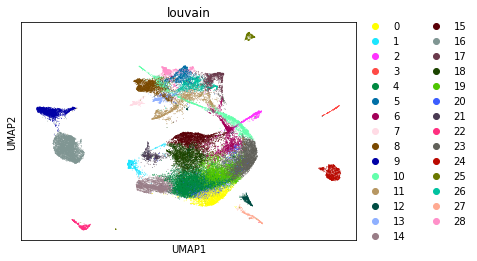

CPU times: user 945 ms, sys: 171 ms, total: 1.12 s
Wall time: 869 ms


In [22]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [23]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 85.1 ms, sys: 6.3 ms, total: 91.4 ms
Wall time: 90.2 ms


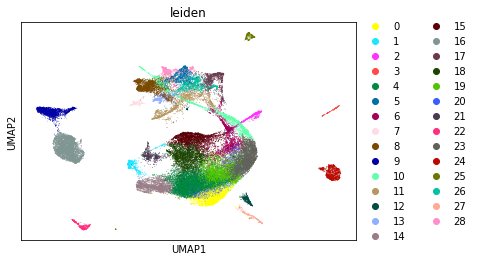

CPU times: user 959 ms, sys: 148 ms, total: 1.11 s
Wall time: 859 ms


In [24]:
%%time
sc.pl.umap(adata, color=["leiden"])

And we can visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

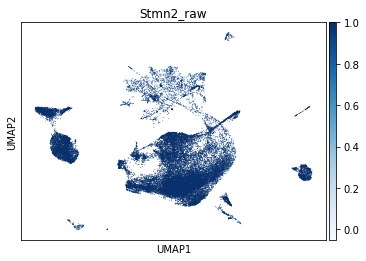

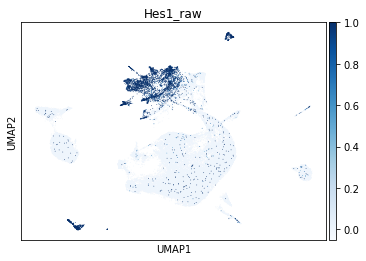

CPU times: user 874 ms, sys: 229 ms, total: 1.1 s
Wall time: 611 ms


In [25]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [26]:
import cudf
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
genes = cudf.Series(genes)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [27]:
genes

0                Xkr4
1               Sox17
2             Gm37323
3               Oprk1
4              Npbwr1
            ...      
3995             Emx2
3996        Rab11fip2
3997    E330013P04Rik
3998           Nanos1
3999           Csf2ra
Length: 4000, dtype: object

In [28]:
%%time

import cupy as cp
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    cp.array(adata.X), 
    cluster_labels, 
    genes, 
    n_genes=50, groups='all', reference='rest')

CPU times: user 2.54 s, sys: 732 ms, total: 3.27 s
Wall time: 3.28 s


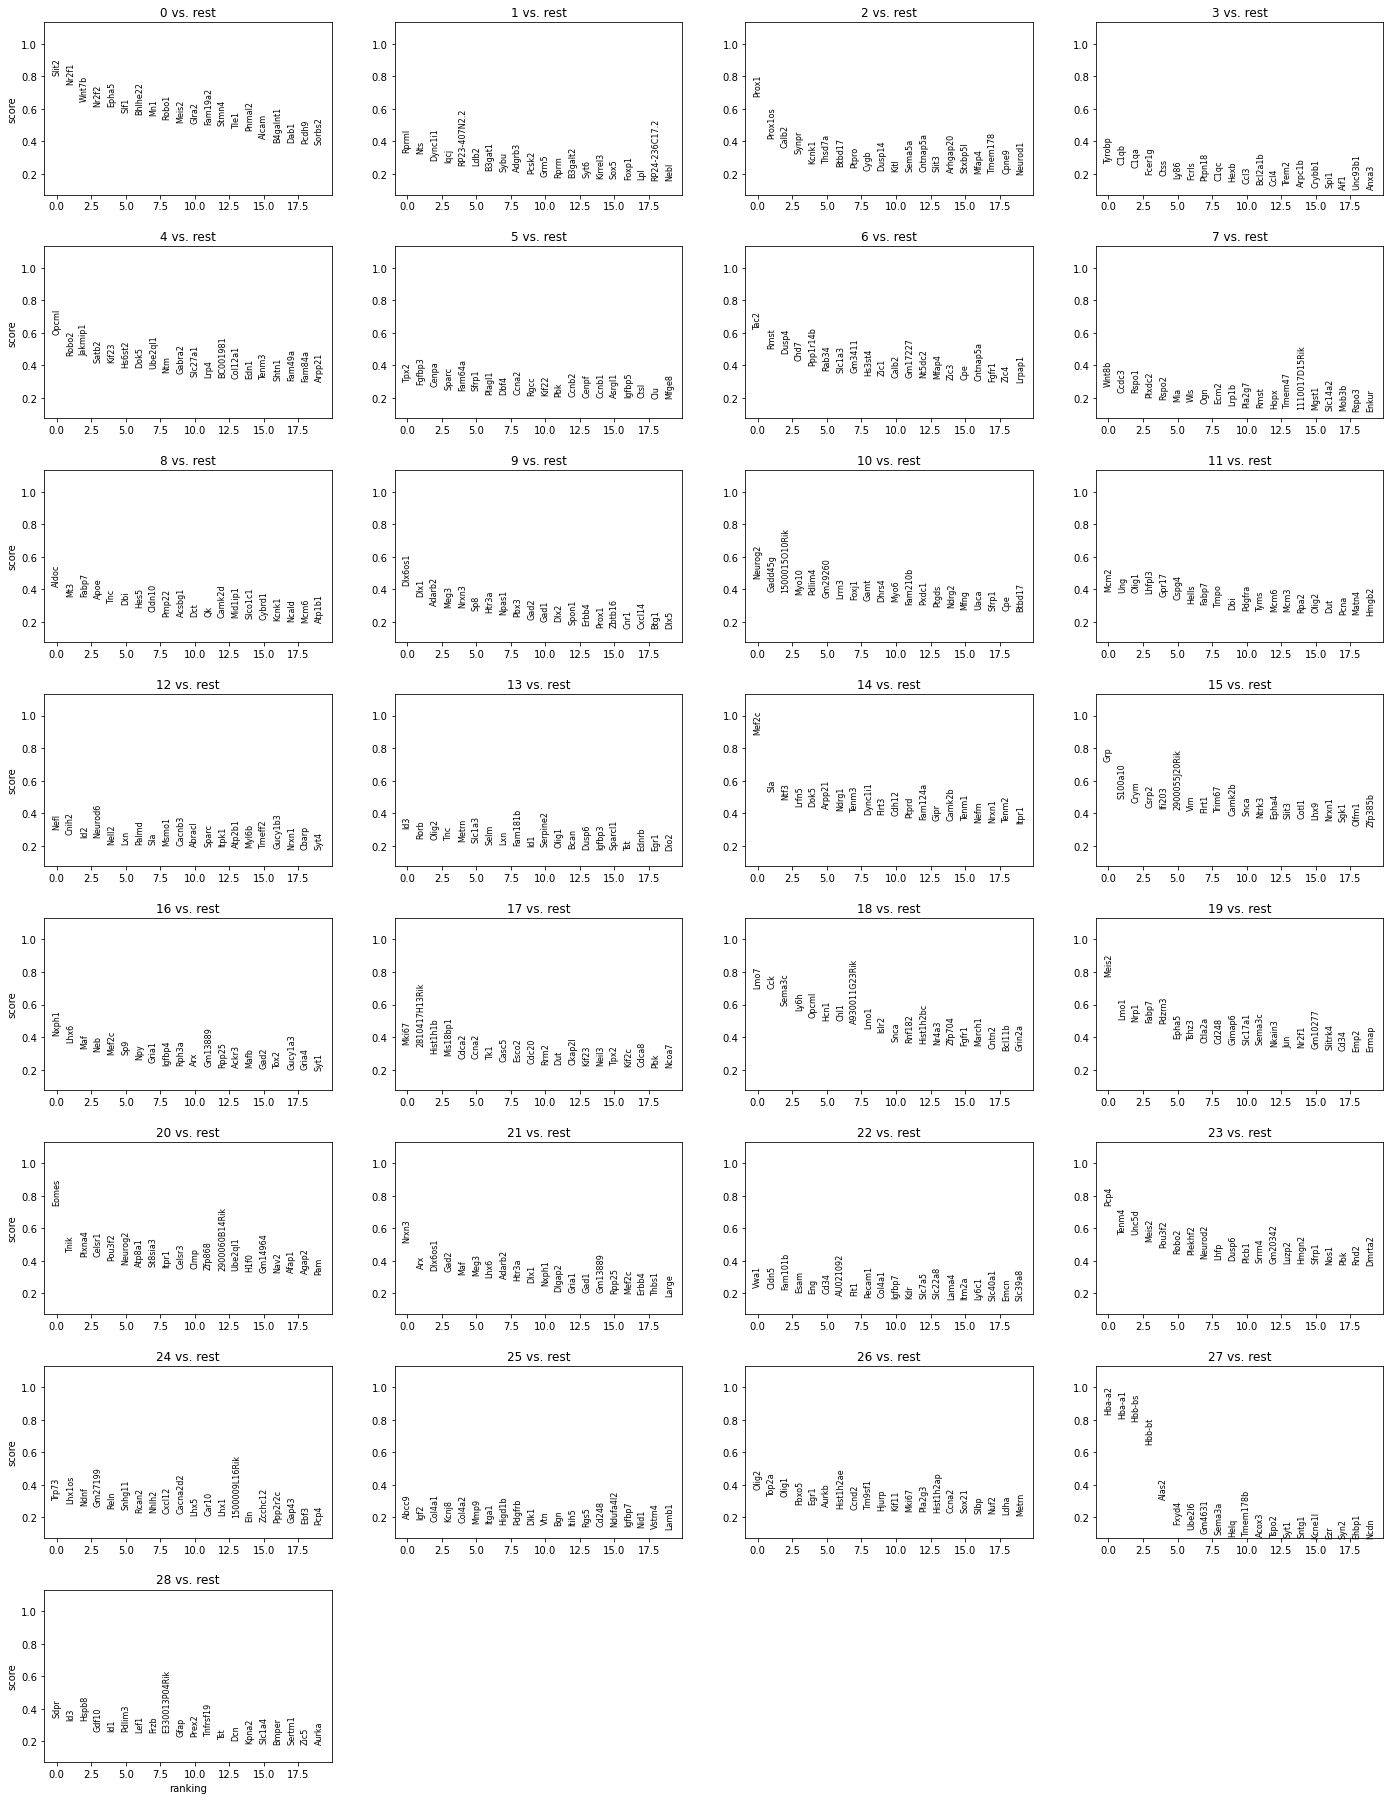

CPU times: user 4.48 s, sys: 2.5 s, total: 6.98 s
Wall time: 6.73 s


In [29]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

In [30]:
print("Full time: %s" % (time.time() - start))

Full time: 62.03522038459778


In [31]:
adata.write("1M_cells_50k_gpu.h5py")